# Monte Carlo Simulation Results Explorer

This notebook demonstrates how to load, explore, and analyze results from Monte Carlo FVS batch simulations.

**Topics covered:**
1. Loading results with `load_mc_results()`
2. Database schema overview (5 tables)
3. Batch metadata and configuration
4. Run registry - sampled parameters
5. Run summary - outcome metrics
6. Parameter → outcome analysis
7. Time series trajectories
8. Aggregation logic (flow vs pool fields)
9. Error handling

**Data source:** `outputs/parallel_demo/mc_results.db` (70 runs across 7 stands)

In [1]:
# Standard imports
import sys
import sqlite3
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Add src to path for library imports
sys.path.insert(0, str(Path("..").resolve() / "src"))

import fvs_tools as fvs
from fvs_tools.monte_carlo import load_mc_results

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

print("✓ Imports loaded successfully")

✓ Imports loaded successfully


## 1. Load Monte Carlo Results

The `load_mc_results()` function reads all tables from the results database into a dictionary of DataFrames.

In [2]:
# Path to results database - use large_mc output
results_db = Path("../outputs/large_mc/mc_results.db")

if not results_db.exists():
    print(f"❌ Results database not found: {results_db}")
    print("   Run the large MC script first: nohup uv run python scripts/run_large_mc.py > large_mc.log 2>&1 &")
else:
    print(f"✓ Found results database: {results_db}")
    print(f"  File size: {results_db.stat().st_size / 1024:.1f} KB")

✓ Found results database: ../outputs/large_mc/mc_results.db
  File size: 232.0 KB


In [3]:
# Load all results
results = load_mc_results(results_db)

print("Loaded tables:")
for key, value in results.items():
    if isinstance(value, pd.DataFrame):
        print(f"  {key:12s}: {len(value):4d} rows × {len(value.columns):2d} columns")
    elif isinstance(value, dict):
        print(f"  {key:12s}: dict with {len(value)} keys")
    else:
        print(f"  {key:12s}: {type(value).__name__}")

Loaded tables:
  batch_meta  : dict with 8 keys
  registry    :  100 rows × 15 columns
  summary     :  100 rows × 12 columns
  timeseries  : 1100 rows × 12 columns
  errors      :    0 rows ×  6 columns


## 2. Understanding the Database Schema

The Monte Carlo results database has 5 tables:

| Table | Purpose | Key Columns |
|-------|---------|-------------|
| **MC_BatchMeta** | Batch configuration | batch_id, n_samples, n_workers, status |
| **MC_RunRegistry** | Sampled parameters per run | run_id, run_seed, parameter columns |
| **MC_RunSummary** | Aggregated outcomes per run | final_total_carbon, min_canopy_cover, cumulative_harvest_bdft |
| **MC_TimeSeries** | Year-by-year trajectories | year, carbon pools, canopy_cover_pct, cumulative_harvest |
| **MC_BatchErrors** | Failed run diagnostics | run_id, error_message, traceback |

In [4]:
# Inspect the database schema directly
conn = sqlite3.connect(results_db)
cursor = conn.cursor()

# Get table names
cursor.execute("SELECT name FROM sqlite_master WHERE type='table' ORDER BY name")
tables = [row[0] for row in cursor.fetchall()]

print("Database Tables:")
print("=" * 70)

for table in tables:
    cursor.execute(f"PRAGMA table_info({table})")
    columns = cursor.fetchall()
    
    print(f"\n{table}:")
    print(f"  Columns: {len(columns)}")
    
    # Show first few column names
    col_names = [col[1] for col in columns[:5]]
    if len(columns) > 5:
        col_names.append(f"... +{len(columns) - 5} more")
    print(f"  {', '.join(col_names)}")
    
    # Show row count
    cursor.execute(f"SELECT COUNT(*) FROM {table}")
    count = cursor.fetchone()[0]
    print(f"  Rows: {count}")

conn.close()

Database Tables:

MC_BatchErrors:
  Columns: 6
  batch_id, run_id, stand_id, error_type, error_msg, ... +1 more
  Rows: 0

MC_BatchMeta:
  Columns: 8
  batch_id, batch_seed, n_samples, n_workers, created_at, ... +3 more
  Rows: 1

MC_RunRegistry:
  Columns: 15
  batch_id, run_id, run_seed, status, created_at, ... +10 more
  Rows: 100

MC_RunSummary:
  Columns: 12
  batch_id, run_id, final_total_carbon, avg_carbon_stock, final_live_carbon, ... +7 more
  Rows: 100

MC_TimeSeries:
  Columns: 12
  batch_id, run_id, year, aboveground_c_live, standing_dead_c, ... +7 more
  Rows: 1100


## 3. Batch Metadata

The `batch_meta` dict contains configuration information about the simulation batch.

In [5]:
batch_meta = results['batch_meta']

print("Batch Configuration:")
print("=" * 50)
for key, value in batch_meta.items():
    if key == 'config_json':
        print(f"  {key:15s}: <full config stored>")
    else:
        print(f"  {key:15s}: {value}")

Batch Configuration:
  batch_id       : mc_20251210_025912
  batch_seed     : 42
  n_samples      : 100
  n_workers      : 20
  created_at     : 2025-12-10T02:59:12.905131
  completed_at   : 2025-12-10T03:33:38.661244
  status         : complete
  config_json    : <full config stored>


## 4. Run Registry - Sampled Parameters

The registry table stores the sampled parameter values for each run. In this timing test, all parameters are constant (n_samples=1).

In [6]:
registry = results['registry']

print(f"Registry: {len(registry)} runs")
print(f"\nColumns: {list(registry.columns)}")
print(f"\nFirst 5 rows:")
display(registry.head())

Registry: 100 runs

Columns: ['batch_id', 'run_id', 'run_seed', 'status', 'created_at', 'completed_at', 'thin_q_factor', 'thin_residual_ba', 'thin_trigger_ba', 'thin_min_dbh', 'thin_max_dbh', 'min_harvest_volume', 'mortality_multiplier', 'enable_calibration', 'fvs_random_seed']

First 5 rows:


,batch_id,run_id,run_seed,status,created_at,completed_at,thin_q_factor,thin_residual_ba,thin_trigger_ba,thin_min_dbh,thin_max_dbh,min_harvest_volume,mortality_multiplier,enable_calibration,fvs_random_seed
0,mc_20251210_025912,0,83811,complete,2025-12-10T02:59:12.906202,None,1.611331,68.538762,102.346756,None,None,3704.990352,0.855815,None,None
1,mc_20251210_025912,1,97081,complete,2025-12-10T02:59:12.906207,None,2.392180,52.173471,107.657655,None,None,3937.275950,0.811919,None,None
2,mc_20251210_025912,2,66238,complete,2025-12-10T02:59:12.906209,None,2.102019,64.031127,116.480588,None,None,4339.039642,1.080530,None,None
3,mc_20251210_025912,3,58879,complete,2025-12-10T02:59:12.906211,None,2.089266,70.235761,95.194963,None,None,4896.278790,1.122328,None,None
4,mc_20251210_025912,4,44598,complete,2025-12-10T02:59:12.906212,None,1.777871,55.382844,117.904824,None,None,4259.854601,0.840884,None,None


In [7]:
# Check parameter distributions (useful for multi-sample batches)
param_cols = [
    'mortality_multiplier', 'enable_calibration', 'fvs_random_seed',
    'thin_q_factor', 'thin_residual_ba', 'thin_trigger_ba'
]

available_params = [col for col in param_cols if col in registry.columns]

print("Parameter Summary Statistics:")
print("=" * 70)
for param in available_params:
    values = registry[param].dropna()
    if len(values) > 0:
        print(f"\n{param}:")
        if registry[param].dtype in ['int64', 'float64']:
            print(f"  Range: {values.min()} to {values.max()}")
            print(f"  Mean: {values.mean():.2f}")
            print(f"  Std: {values.std():.2f}")
        else:
            print(f"  Values: {values.unique()}")

Parameter Summary Statistics:

mortality_multiplier:
  Range: 0.8008621513405706 to 1.1884313510454472
  Mean: 1.00
  Std: 0.12

thin_q_factor:
  Range: 1.5520856082432555 to 2.479797953828836
  Mean: 2.01
  Std: 0.28

thin_residual_ba:
  Range: 50.01014849243219 to 74.90303450600243
  Mean: 61.60
  Std: 7.62

thin_trigger_ba:
  Range: 95.19496279034183 to 124.9261281948533
  Mean: 110.41
  Std: 7.69


## 5. Run Summary - Outcome Metrics

The summary table contains aggregated metrics for each completed run:

### Carbon Metrics (tons/ac)
- `final_total_carbon`: Live + Dead + Stored at final year
- `avg_carbon_stock`: Mean total carbon over all years
- `final_live_carbon`: Aboveground live carbon at final year
- `final_dead_carbon`: Standing dead carbon at final year
- `final_stored_carbon`: Carbon in wood products pool at final year

### Canopy Metrics (%)
- `min_canopy_cover`: Minimum across all years (bottleneck metric)
- `final_canopy_cover`: Canopy cover at final year

### Harvest Metrics
- `cumulative_harvest_bdft`: Total board feet harvested over all years (per acre)

In [8]:
summary = results['summary']

print(f"Summary: {len(summary)} completed runs")
print(f"\nColumns: {list(summary.columns)}")
print(f"\nFirst 5 rows:")
display(summary.head())

Summary: 100 completed runs

Columns: ['batch_id', 'run_id', 'final_total_carbon', 'avg_carbon_stock', 'final_live_carbon', 'final_dead_carbon', 'final_stored_carbon', 'min_canopy_cover', 'final_canopy_cover', 'cumulative_harvest_bdft', 'run_duration_sec', 'n_stands']

First 5 rows:


,batch_id,run_id,final_total_carbon,avg_carbon_stock,final_live_carbon,final_dead_carbon,final_stored_carbon,min_canopy_cover,final_canopy_cover,cumulative_harvest_bdft,run_duration_sec,n_stands
0,mc_20251210_025912,17,33.933124,27.055109,24.585520,1.532824,7.814781,36.652917,47.372000,11395.956646,None,268
1,mc_20251210_025912,5,34.612457,26.745567,21.282329,1.521713,11.808415,37.285813,54.846907,15802.679689,None,268
2,mc_20251210_025912,11,34.823781,26.927331,21.818255,1.572033,11.433493,37.109947,54.603407,15356.511229,None,268
3,mc_20251210_025912,9,32.035570,25.697815,21.464434,1.407034,9.164102,34.886581,46.873564,13208.592585,None,268
4,mc_20251210_025912,14,33.228045,26.127818,23.731820,1.281102,8.215123,36.281271,46.981791,12029.769614,None,268


In [9]:
# Summary statistics for key outcomes
outcome_cols = [
    'final_total_carbon', 'avg_carbon_stock',
    'min_canopy_cover', 'final_canopy_cover',
    'cumulative_harvest_bdft'
]

print("Outcome Metrics Summary:")
print("=" * 70)
display(summary[outcome_cols].describe())

Outcome Metrics Summary:


,final_total_carbon,avg_carbon_stock,min_canopy_cover,final_canopy_cover,cumulative_harvest_bdft
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,33.086731,25.639423,35.960476,52.935311,15138.482325
std,1.410950,1.018848,1.418223,5.579457,2472.171609
min,30.216630,23.542626,32.479064,45.496253,11395.956646
25%,31.994198,24.925036,34.978199,47.373259,12865.134887
50%,33.118120,25.560836,36.005893,54.055151,14818.551621
75%,34.188885,26.463456,37.042633,58.208285,17382.553209
max,35.831339,27.696296,38.422056,62.115818,19585.280781


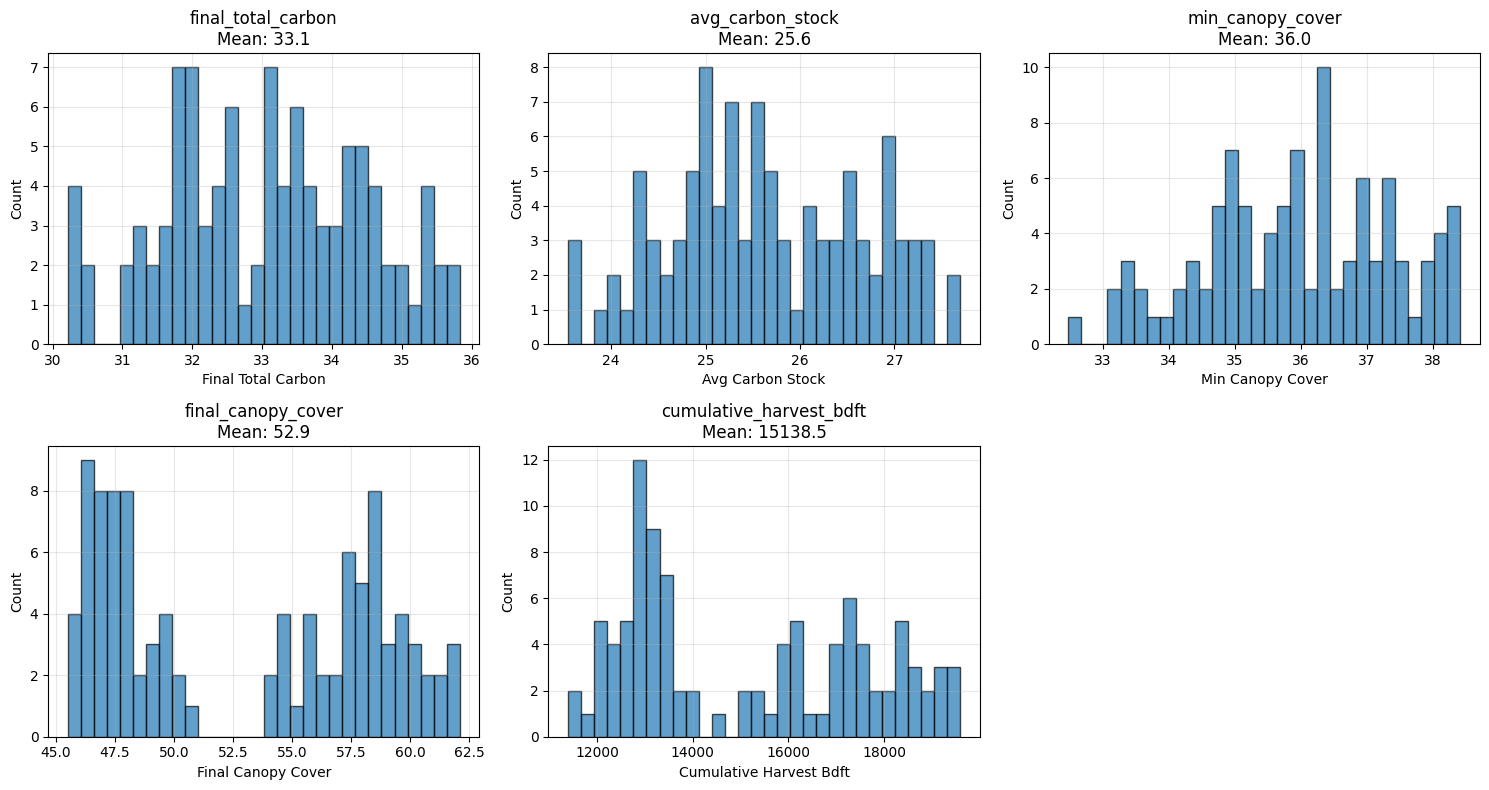

In [10]:
# Visualize outcome distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(outcome_cols):
    ax = axes[i]
    values = summary[col].dropna()
    
    if len(values) > 0:
        ax.hist(values, bins=30, edgecolor='black', alpha=0.7)
        ax.set_xlabel(col.replace('_', ' ').title())
        ax.set_ylabel('Count')
        ax.set_title(f'{col}\nMean: {values.mean():.1f}')
        ax.grid(alpha=0.3)

# Hide extra subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

## 6. Analyzing Parameter → Outcome Relationships

Join registry and summary to explore how parameter values influence outcomes.

**Note:** This timing run has no parameter variation (n_samples=1), so relationships won't be visible. For a real Monte Carlo study with varying parameters, you'd see clear trends.

In [11]:
# Join registry and summary
merged = registry.merge(summary, on=['batch_id', 'run_id'], how='inner')

print(f"Merged data: {len(merged)} rows × {len(merged.columns)} columns")
print(f"\nAvailable for analysis:")
print(f"  Parameters: {[col for col in available_params if col in merged.columns]}")
print(f"  Outcomes: {outcome_cols}")

display(merged.head())

Merged data: 100 rows × 25 columns

Available for analysis:
  Parameters: ['mortality_multiplier', 'enable_calibration', 'fvs_random_seed', 'thin_q_factor', 'thin_residual_ba', 'thin_trigger_ba']
  Outcomes: ['final_total_carbon', 'avg_carbon_stock', 'min_canopy_cover', 'final_canopy_cover', 'cumulative_harvest_bdft']


,batch_id,run_id,run_seed,status,created_at,completed_at,thin_q_factor,thin_residual_ba,thin_trigger_ba,thin_min_dbh,thin_max_dbh,min_harvest_volume,mortality_multiplier,enable_calibration,fvs_random_seed,final_total_carbon,avg_carbon_stock,final_live_carbon,final_dead_carbon,final_stored_carbon,min_canopy_cover,final_canopy_cover,cumulative_harvest_bdft,run_duration_sec,n_stands
0,mc_20251210_025912,0,83811,complete,2025-12-10T02:59:12.906202,None,1.611331,68.538762,102.346756,None,None,3704.990352,0.855815,None,None,32.620622,25.654040,22.451567,0.944332,9.224723,35.979659,49.349636,12776.461752,None,268
1,mc_20251210_025912,1,97081,complete,2025-12-10T02:59:12.906207,None,2.392180,52.173471,107.657655,None,None,3937.275950,0.811919,None,None,32.861279,24.798000,16.420060,0.863175,15.578044,35.751993,61.123158,19585.280781,None,268
2,mc_20251210_025912,2,66238,complete,2025-12-10T02:59:12.906209,None,2.102019,64.031127,116.480588,None,None,4339.039642,1.080530,None,None,34.404310,26.468636,20.644983,1.492333,12.266994,37.026895,55.878971,16222.037547,None,268
3,mc_20251210_025912,3,58879,complete,2025-12-10T02:59:12.906211,None,2.089266,70.235761,95.194963,None,None,4896.278790,1.122328,None,None,34.478460,26.455814,19.983233,1.242743,13.252484,37.187091,57.590581,16155.960379,None,268
4,mc_20251210_025912,4,44598,complete,2025-12-10T02:59:12.906212,None,1.777871,55.382844,117.904824,None,None,4259.854601,0.840884,None,None,31.802650,24.928601,21.637577,0.915938,9.249135,34.727525,47.237808,13587.262322,None,268


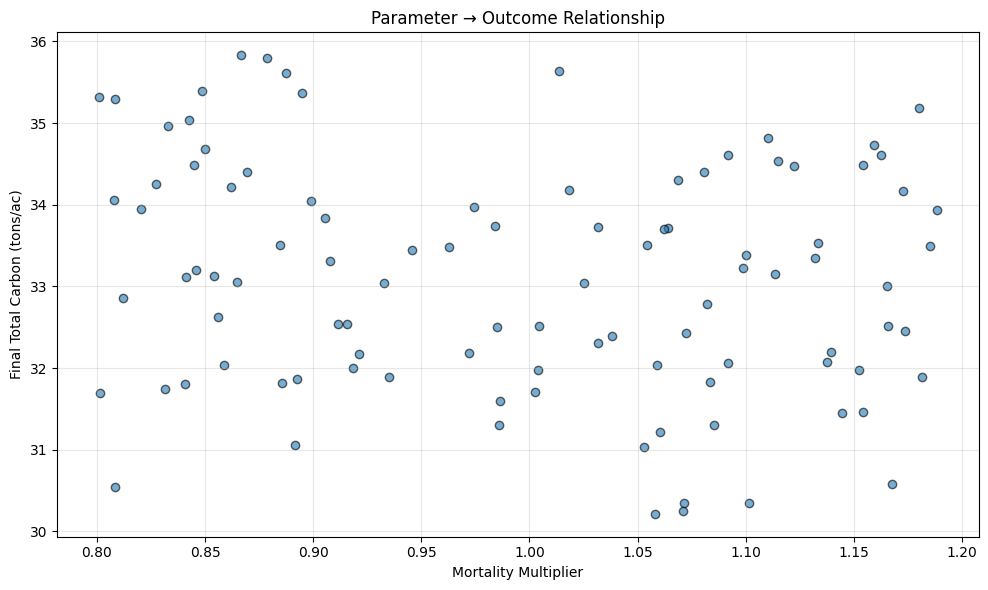

In [12]:
# Example: Plot mortality_multiplier vs final_total_carbon
# (Would show relationship in a multi-sample batch)

if len(merged) == 0:
    print("⚠️ No merged data available (summary is empty)")
elif 'mortality_multiplier' in merged.columns:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    mort_values = merged['mortality_multiplier'].dropna()
    
    if len(mort_values) == 0:
        print("⚠️ No mortality_multiplier values available")
    elif len(mort_values.unique()) > 1:
        # Multi-sample batch: scatter plot
        ax.scatter(merged['mortality_multiplier'], merged['final_total_carbon'], 
                   alpha=0.6, edgecolors='black')
        ax.set_xlabel('Mortality Multiplier')
        ax.set_ylabel('Final Total Carbon (tons/ac)')
        ax.set_title('Parameter → Outcome Relationship')
        ax.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        # Single-sample batch: histogram of outcomes
        ax.hist(merged['final_total_carbon'].dropna(), bins=30, edgecolor='black', alpha=0.7)
        ax.set_xlabel('Final Total Carbon (tons/ac)')
        ax.set_ylabel('Count')
        ax.set_title('Outcome Distribution (Single Parameter Value)')
        ax.text(0.05, 0.95, 
                f'mortality_multiplier = {mort_values.iloc[0]}',
                transform=ax.transAxes, 
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        ax.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
else:
    print("⚠️ mortality_multiplier not in merged data")

## 7. Time Series Data

The time series table contains year-by-year trajectories for each run. This allows us to:
- Plot individual stand trajectories
- Compute mean trajectories with uncertainty bands
- Identify critical time points (e.g., when canopy drops below threshold)

In [13]:
timeseries = results['timeseries']

print(f"Time Series: {len(timeseries)} observations")
print(f"\nColumns: {list(timeseries.columns)}")
print(f"\nYear range: {timeseries['year'].min()} to {timeseries['year'].max()}")
print(f"Number of runs: {timeseries['run_id'].nunique()}")
print(f"\nFirst 10 rows:")
display(timeseries.head(10))

Time Series: 1100 observations

Columns: ['batch_id', 'run_id', 'year', 'aboveground_c_live', 'standing_dead_c', 'merch_carbon_stored', 'total_carbon', 'canopy_cover_pct', 'ba', 'tpa', 'harvest_bdft', 'cumulative_harvest']

Year range: 2023 to 2123
Number of runs: 100

First 10 rows:


,batch_id,run_id,year,aboveground_c_live,standing_dead_c,merch_carbon_stored,total_carbon,canopy_cover_pct,ba,tpa,harvest_bdft,cumulative_harvest
0,mc_20251210_025912,17,2023,17.069442,0.863551,1.968041,19.901034,41.993021,92.828080,286.295336,1745.776321,1745.776321
1,mc_20251210_025912,17,2033,18.118283,1.473684,1.928507,21.520474,37.677904,85.464925,289.909805,392.471891,2138.248213
2,mc_20251210_025912,17,2043,19.901878,1.431127,1.928112,23.261117,36.652917,88.529423,336.926448,274.025804,2412.274016
3,mc_20251210_025912,17,2053,20.927540,1.431883,2.206552,24.565975,37.681708,92.497766,302.864920,519.627433,2931.901449
4,mc_20251210_025912,17,2063,21.188979,1.563532,2.799536,25.552046,38.477209,93.424036,452.173339,848.924042,3780.825491
5,mc_20251210_025912,17,2073,22.272958,1.368319,3.195267,26.836543,38.120599,93.598194,414.851140,751.054407,4531.879899
6,mc_20251210_025912,17,2083,22.699247,1.348136,3.947128,27.994511,39.795600,94.948730,481.232767,1089.664355,5621.544254
7,mc_20251210_025912,17,2093,23.339491,1.406573,4.724995,29.471059,42.174399,96.555518,451.176335,1174.239437,6795.783692
8,mc_20251210_025912,17,2103,22.652810,1.481012,6.165334,30.299157,44.751973,96.018829,485.524394,1790.179489,8585.963181
9,mc_20251210_025912,17,2113,23.828512,1.448183,6.874195,32.150889,45.881683,95.904012,495.420579,1321.339473,9907.302654


Plotting 50 runs (total: 100)


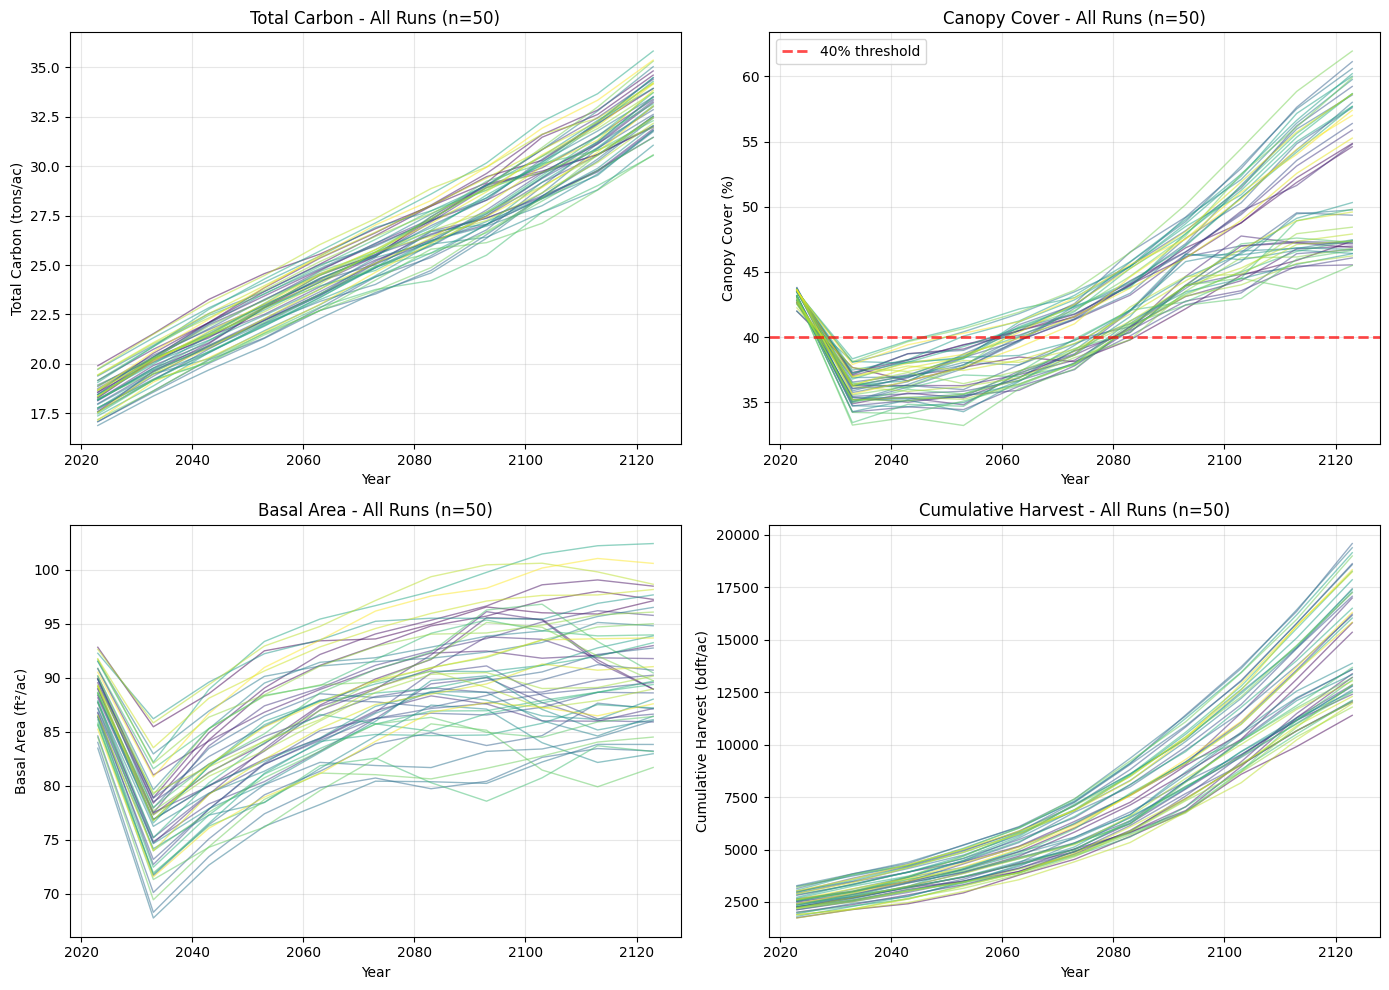

In [14]:
# Plot spaghetti plot: all runs overlaid
if len(timeseries) == 0:
    print("⚠️ No time series data available")
else:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Get all unique run IDs (limit to 50 for visibility)
    run_ids = timeseries['run_id'].unique()
    n_runs = len(run_ids)
    display_runs = min(n_runs, 50)
    
    # Color map for runs
    colors = plt.cm.viridis(np.linspace(0, 1, display_runs))
    
    print(f"Plotting {display_runs} runs (total: {n_runs})")
    
    # Carbon pools
    ax = axes[0, 0]
    for i, run_id in enumerate(run_ids[:display_runs]):
        run_data = timeseries[timeseries['run_id'] == run_id].sort_values('year')
        ax.plot(run_data['year'], run_data['total_carbon'], 
                color=colors[i], alpha=0.5, linewidth=1)
    ax.set_xlabel('Year')
    ax.set_ylabel('Total Carbon (tons/ac)')
    ax.set_title(f'Total Carbon - All Runs (n={display_runs})')
    ax.grid(alpha=0.3)
    
    # Canopy cover
    ax = axes[0, 1]
    for i, run_id in enumerate(run_ids[:display_runs]):
        run_data = timeseries[timeseries['run_id'] == run_id].sort_values('year')
        ax.plot(run_data['year'], run_data['canopy_cover_pct'], 
                color=colors[i], alpha=0.5, linewidth=1)
    ax.axhline(y=40, color='red', linestyle='--', alpha=0.7, linewidth=2, label='40% threshold')
    ax.set_xlabel('Year')
    ax.set_ylabel('Canopy Cover (%)')
    ax.set_title(f'Canopy Cover - All Runs (n={display_runs})')
    ax.legend()
    ax.grid(alpha=0.3)
    
    # Basal area
    ax = axes[1, 0]
    for i, run_id in enumerate(run_ids[:display_runs]):
        run_data = timeseries[timeseries['run_id'] == run_id].sort_values('year')
        ax.plot(run_data['year'], run_data['ba'], 
                color=colors[i], alpha=0.5, linewidth=1)
    ax.set_xlabel('Year')
    ax.set_ylabel('Basal Area (ft²/ac)')
    ax.set_title(f'Basal Area - All Runs (n={display_runs})')
    ax.grid(alpha=0.3)
    
    # Cumulative harvest
    ax = axes[1, 1]
    for i, run_id in enumerate(run_ids[:display_runs]):
        run_data = timeseries[timeseries['run_id'] == run_id].sort_values('year')
        ax.plot(run_data['year'], run_data['cumulative_harvest'], 
                color=colors[i], alpha=0.5, linewidth=1)
    ax.set_xlabel('Year')
    ax.set_ylabel('Cumulative Harvest (bdft/ac)')
    ax.set_title(f'Cumulative Harvest - All Runs (n={display_runs})')
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

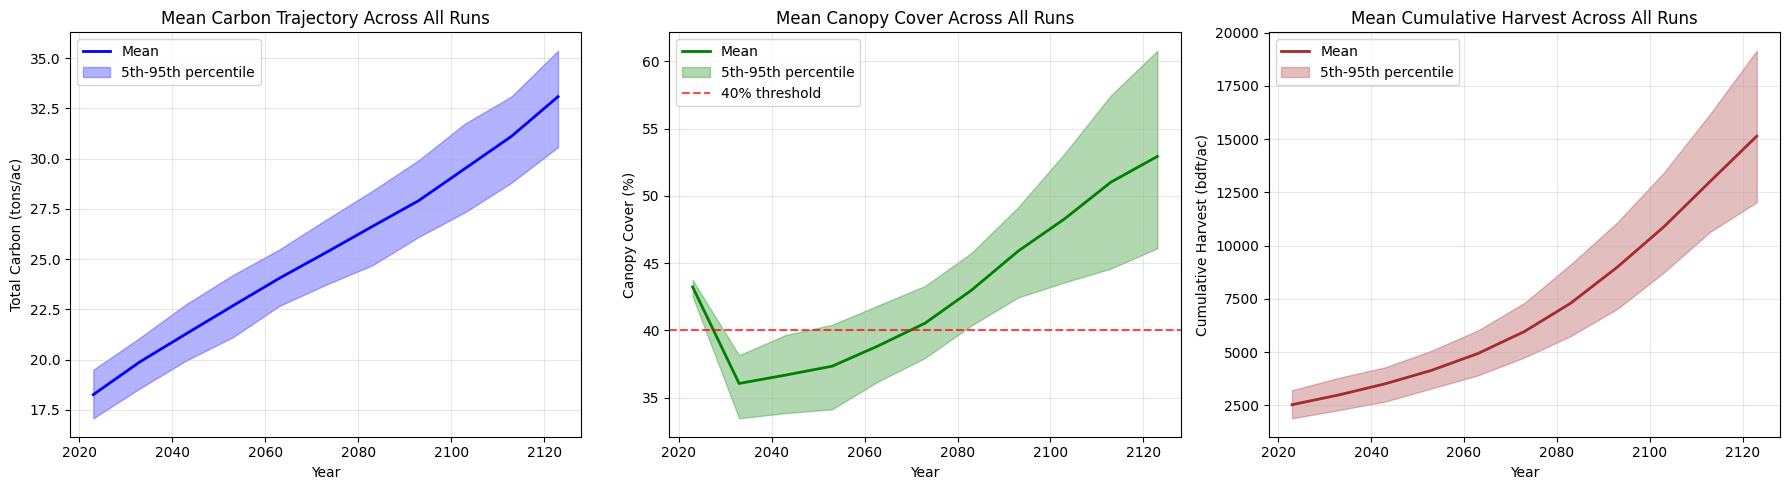

In [15]:
# Aggregate across all runs: mean trajectory with percentile bands
if len(timeseries) == 0:
    print("⚠️ No time series data available for aggregation")
else:
    ts_agg = timeseries.groupby('year').agg({
        'total_carbon': ['mean', lambda x: x.quantile(0.05), lambda x: x.quantile(0.95)],
        'canopy_cover_pct': ['mean', lambda x: x.quantile(0.05), lambda x: x.quantile(0.95)],
        'cumulative_harvest': ['mean', lambda x: x.quantile(0.05), lambda x: x.quantile(0.95)]
    }).reset_index()

    # Flatten column names
    ts_agg.columns = ['year', 
                      'total_carbon_mean', 'total_carbon_p5', 'total_carbon_p95',
                      'canopy_cover_pct_mean', 'canopy_cover_pct_p5', 'canopy_cover_pct_p95',
                      'cumulative_harvest_mean', 'cumulative_harvest_p5', 'cumulative_harvest_p95']

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Total carbon with 5th-95th percentile band
    ax = axes[0]
    ax.plot(ts_agg['year'], ts_agg['total_carbon_mean'], 
            linewidth=2, label='Mean', color='blue')
    ax.fill_between(ts_agg['year'].astype(float), 
                    ts_agg['total_carbon_p5'].astype(float),
                    ts_agg['total_carbon_p95'].astype(float),
                    alpha=0.3, label='5th-95th percentile', color='blue')
    ax.set_xlabel('Year')
    ax.set_ylabel('Total Carbon (tons/ac)')
    ax.set_title('Mean Carbon Trajectory Across All Runs')
    ax.legend()
    ax.grid(alpha=0.3)

    # Canopy cover with 5th-95th percentile band
    ax = axes[1]
    ax.plot(ts_agg['year'], ts_agg['canopy_cover_pct_mean'], 
            linewidth=2, color='green', label='Mean')
    ax.fill_between(ts_agg['year'].astype(float), 
                    ts_agg['canopy_cover_pct_p5'].astype(float),
                    ts_agg['canopy_cover_pct_p95'].astype(float),
                    alpha=0.3, color='green', label='5th-95th percentile')
    ax.axhline(y=40, color='red', linestyle='--', alpha=0.7, label='40% threshold')
    ax.set_xlabel('Year')
    ax.set_ylabel('Canopy Cover (%)')
    ax.set_title('Mean Canopy Cover Across All Runs')
    ax.legend()
    ax.grid(alpha=0.3)

    # Cumulative harvest with 5th-95th percentile band
    ax = axes[2]
    ax.plot(ts_agg['year'], ts_agg['cumulative_harvest_mean'], 
            linewidth=2, color='brown', label='Mean')
    ax.fill_between(ts_agg['year'].astype(float), 
                    ts_agg['cumulative_harvest_p5'].astype(float),
                    ts_agg['cumulative_harvest_p95'].astype(float),
                    alpha=0.3, color='brown', label='5th-95th percentile')
    ax.set_xlabel('Year')
    ax.set_ylabel('Cumulative Harvest (bdft/ac)')
    ax.set_title('Mean Cumulative Harvest Across All Runs')
    ax.legend()
    ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

## 8. Understanding Aggregation Logic

### Critical Distinction: Flow vs Pool Fields

FVS outputs contain two types of fields:

1. **POOL FIELDS** (State variables):
   - Represent the state at end of period
   - Examples: BA, carbon pools, canopy cover, TPH
   - **Aggregation**: Use value at specific time point (min, max, final, mean over time)

2. **FLOW FIELDS** (Flux variables):
   - Represent per-period activity
   - Examples: RBdFt (harvest this period), mortality this period
   - **Aggregation**: SUM across periods for cumulative total

### How Summary Metrics Are Computed

#### `min_canopy_cover` (Pool field)
```python
# Step 1: Average across stands for each year
canopy_by_year = combined.groupby('Year')['canopy'].mean()

# Step 2: Find minimum across all years
min_canopy_cover = canopy_by_year.min()
```

#### `cumulative_harvest_bdft` (Flow field)
```python
# Step 1: Average per-period harvest across stands for each year
harvest_by_year = summary_df.groupby('Year')['RBdFt'].mean()

# Step 2: Sum across all years for total cumulative
cumulative_harvest_bdft = harvest_by_year.sum()
```

This distinction is **critical** for correct interpretation!

In [16]:
# Demonstrate the aggregation logic with sample data

if len(timeseries) == 0:
    print("⚠️ No time series data available for demonstration")
else:
    # Pick a run and show how metrics are derived from time series
    demo_run_id = timeseries['run_id'].iloc[0]
    demo_ts = timeseries[timeseries['run_id'] == demo_run_id].sort_values('year')

    print("Aggregation Logic Demonstration")
    print("=" * 70)
    print(f"\nUsing Run {demo_run_id} as example\n")

    # Canopy cover (POOL) - min across years
    canopy_min = demo_ts['canopy_cover_pct'].min()
    canopy_final = demo_ts['canopy_cover_pct'].iloc[-1]
    print("POOL FIELD - Canopy Cover:")
    print(f"  Time series values: {demo_ts['canopy_cover_pct'].values[:5]}...")
    print(f"  min_canopy_cover = {canopy_min:.2f}%")
    print(f"  final_canopy_cover = {canopy_final:.2f}%")
    print(f"  → Use value at time point (min, final, etc.)\n")

    # Harvest (FLOW) - sum across years
    if 'harvest_bdft' in demo_ts.columns:
        harvest_per_period = demo_ts['harvest_bdft']
        cumulative = harvest_per_period.sum()
        print("FLOW FIELD - Harvest:")
        print(f"  Per-period values: {harvest_per_period.values[:5]}...")
        print(f"  cumulative_harvest_bdft = {cumulative:.0f} (sum of all periods)")
        print(f"  → Sum across periods for total\n")

    # Carbon (POOL) - final and average
    carbon_final = demo_ts['total_carbon'].iloc[-1]
    carbon_avg = demo_ts['total_carbon'].mean()
    print("POOL FIELD - Total Carbon:")
    print(f"  Time series values: {demo_ts['total_carbon'].values[:5]}...")
    print(f"  final_total_carbon = {carbon_final:.2f} tons/ac")
    print(f"  avg_carbon_stock = {carbon_avg:.2f} tons/ac (mean across years)")
    print(f"  → Use final value or average\n")

    # Cross-check with summary table
    summary_match = summary[summary['run_id'] == demo_run_id]
    if len(summary_match) > 0:
        summary_row = summary_match.iloc[0]
        print("\nCross-Check with Summary Table:")
        print(f"  Summary.min_canopy_cover = {summary_row['min_canopy_cover']:.2f}%")
        print(f"  Computed from time series  = {canopy_min:.2f}%")
        print(f"  Match: {abs(summary_row['min_canopy_cover'] - canopy_min) < 0.01}")
    else:
        print("\n(No matching summary row for cross-check)")

Aggregation Logic Demonstration

Using Run 17 as example

POOL FIELD - Canopy Cover:
  Time series values: [41.99302085 37.67790363 36.65291691 37.6817078  38.47720902]...
  min_canopy_cover = 36.65%
  final_canopy_cover = 47.37%
  → Use value at time point (min, final, etc.)

FLOW FIELD - Harvest:
  Per-period values: [1745.77632118  392.47189139  274.02580392  519.62743299  848.92404195]...
  cumulative_harvest_bdft = 11396 (sum of all periods)
  → Sum across periods for total

POOL FIELD - Total Carbon:
  Time series values: [19.90103372 21.52047392 23.26111716 24.56597483 25.55204566]...
  final_total_carbon = 33.93 tons/ac
  avg_carbon_stock = 26.86 tons/ac (mean across years)
  → Use final value or average


Cross-Check with Summary Table:
  Summary.min_canopy_cover = 36.65%
  Computed from time series  = 36.65%
  Match: True


## 9. Error Handling

The errors table logs any runs that failed during execution.

In [17]:
errors = results['errors']

print(f"Errors: {len(errors)} failed runs")

if len(errors) > 0:
    print(f"\nError table columns: {list(errors.columns)}")
    print("\nFailed Runs:")
    # Use actual column names from the schema
    display_cols = [col for col in ['batch_id', 'run_id', 'stand_id', 'error_msg', 'timestamp'] 
                    if col in errors.columns]
    display(errors[display_cols])
    
    # Show error message for first error
    if 'error_msg' in errors.columns:
        print("\nFirst Error Message:")
        print(errors.iloc[0]['error_msg'])
else:
    print("\n✓ All runs completed successfully!")

Errors: 0 failed runs

✓ All runs completed successfully!


## 10. Summary & Next Steps

### What We Covered
1. ✓ Loading Monte Carlo results with `load_mc_results()`
2. ✓ Understanding the 5-table database schema
3. ✓ Exploring batch metadata and configuration
4. ✓ Analyzing sampled parameters (registry)
5. ✓ Examining outcome metrics (summary)
6. ✓ Joining parameters with outcomes for sensitivity analysis
7. ✓ Visualizing time series trajectories
8. ✓ Understanding aggregation logic (flow vs pool fields)
9. ✓ Checking for failed runs

### Key Takeaways
- **Flow fields** (harvest): Sum across periods for cumulative total
- **Pool fields** (carbon, canopy): Use value at time point
- Join `registry` + `summary` to analyze parameter → outcome relationships
- Use `timeseries` for detailed trajectory analysis

### Next Steps
1. **Run a Multi-Sample Batch**: Create a batch with varying parameters to see sensitivity
   ```python
   from fvs_tools.monte_carlo import MonteCarloConfig, UniformParameterSpec
   
   config = MonteCarloConfig(
       n_samples=50,
       parameter_specs=[
           UniformParameterSpec(name='mortality_multiplier', min_value=0.8, max_value=1.2)
       ]
   )
   ```

2. **Explore Other Demo Scripts**:
   - `scripts/demo_monte_carlo_phase2.py` - Full workflow example
   - `scripts/demo_parallel_batch.py` - Parallel execution

3. **Read Documentation**:
   - `docs/plan_monte_carlo.md` - Design decisions
   - `docs/IMPLEMENTATION_PHASE2.md` - Implementation details

In [18]:
# Quick check: verify expected outcome ranges
print("Dataset Sanity Checks:")
print("=" * 50)

if len(summary) == 0:
    print("  ⚠️ No completed runs in summary table")
else:
    checks = [
        ("Completed runs", len(summary) > 0, f"{len(summary)} runs"),
        ("Carbon > 0", (summary['final_total_carbon'] > 0).all(), "All positive"),
        ("Canopy 0-100%", ((summary['min_canopy_cover'] >= 0) & (summary['min_canopy_cover'] <= 100)).all(), "Within range"),
        ("Harvest >= 0", (summary['cumulative_harvest_bdft'] >= 0).all(), "All non-negative"),
        ("Time series years", timeseries['year'].nunique() > 1 if len(timeseries) > 0 else False, 
         f"{timeseries['year'].nunique()} years" if len(timeseries) > 0 else "No data"),
    ]

    for check_name, passed, detail in checks:
        status = "✓" if passed else "✗"
        print(f"  {status} {check_name:20s}: {detail}")

print("\n✓ Notebook complete!")

Dataset Sanity Checks:
  ✓ Completed runs      : 100 runs
  ✓ Carbon > 0          : All positive
  ✓ Canopy 0-100%       : Within range
  ✓ Harvest >= 0        : All non-negative
  ✓ Time series years   : 11 years

✓ Notebook complete!
